### Extract Features from Tweets

#### Author: Lauren Thomas
#### Created: 05/07/2021
#### Last updated: 03/08/2021

###### File description: This file extracts features for the ML file from the Twitter data collected and pre-processed in clean_data


In [1]:
import os 
import pickle
import re
import spacy
import random
import time
import gzip
import gensim
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import seaborn as sns

from patsy import dmatrices
import statsmodels.api as sm


from os import sep
from pprint import pprint
from sklearn.model_selection import train_test_split
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.parsing.porter import PorterStemmer

    

C:\Users\ltswe\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ltswe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ltswe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Working directory
cwd = f"C:{sep}Users{sep}ltswe{sep}Dropbox{sep}Oxford{sep}Thesis"

# Data directory
data_dir = f'D:'

In [3]:
# Import stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['RT'])

# Load English tokenizer model from SPACY, disable parser, ner (for lemmatization)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [4]:
# Path to mallet binary for the model generation
path_to_mallet_binary = f"C:{sep}mallet-2.0.8{sep}bin{sep}mallet"

In [3]:
# First, separate the census tracts into train/test/validate data 
# Bring in tweet data
all_tweets = pd.DataFrame()
tweet_gdf_list = ["tweet_gdf_01", "tweet_gdf_02", "tweet_gdf_03", "tweet_gdf_04", "tweet_gdf_05", 
                  "tweet_gdf_06", "tweet_gdf_07", "tweet_gdf_08", "tweet_gdf_09", "tweet_gdf_10",
                  "tweet_gdf_11", "tweet_gdf_12"]
for df in tweet_gdf_list:
    print(f'Unpickling {df}')
    tweet_df = pickle.load(open(f'{data_dir}{sep}pickle{sep}{df}.pickle', 'rb'))
    all_tweets = all_tweets.append(tweet_df).reset_index(drop=True)

# Bring in label dataframe
labels_gdf = pickle.load(open(f'{data_dir}{sep}pickle{sep}labels_gdf.pickle', 'rb'))

Unpickling tweet_gdf_01
Unpickling tweet_gdf_02
Unpickling tweet_gdf_03
Unpickling tweet_gdf_04
Unpickling tweet_gdf_05
Unpickling tweet_gdf_06
Unpickling tweet_gdf_07
Unpickling tweet_gdf_08
Unpickling tweet_gdf_09
Unpickling tweet_gdf_10
Unpickling tweet_gdf_11
Unpickling tweet_gdf_12


In [4]:
# Drop the census tracts where gentrification couldn't be estimated due to missing data
labels_gdf = labels_gdf.dropna().reset_index(drop=True).rename(columns={'fips_code': 'LocationCT'})

In [5]:
# Sep into train/validate/test
train_labels, testval_labels = train_test_split(labels_gdf, test_size=0.3, random_state=0)
test_labels, val_labels = train_test_split(testval_labels, test_size = 0.5, random_state = 0)

In [6]:
tweets_train_df = all_tweets.merge(train_labels, on='LocationCT')
tweets_test_df = all_tweets.merge(test_labels, on='LocationCT')
tweets_val_df = all_tweets.merge(val_labels,on='LocationCT')


In [7]:
# # Pickle tweets
# pickle.dump(tweets_train_df, open(f'{data_dir}{sep}pickle{sep}tweets_train_df.pickle', 'wb'))
# pickle.dump(tweets_test_df, open(f'{data_dir}{sep}pickle{sep}tweets_test_df.pickle', 'wb'))
# pickle.dump(tweets_val_df, open(f'{data_dir}{sep}pickle{sep}tweets_val_df.pickle', 'wb'))

In [9]:
# Create functions that will be used in the extract_tweets_features function (in next cell)
#Any missing ym-tract-levels not in dataframe should be added in with a '0' count
# Create a function to do this with the given df
def replace_missing(df, tract_list, ym_num_list):
    missing_tracts, missing_ym_num = [],[]
    # Convert all the currently existing tracts/ym/level combos into a dictionary
    existing_dict = df.groupby('LocationCT')[['ym_num', 'tweets_count']].apply(lambda x: x.set_index(['ym_num'])\
                                                        .to_dict()).to_dict()
    # First, go through and find the missing ym-tract-level combos
    for tract in tract_list: 
        for ym_num in ym_num_list:
            # If the following returns a Key Error, then it's not in the existing dict (missing)
            try: 
                existing_dict[tract]['tweets_count'][ym_num]
            except KeyError:
                missing_tracts.append(tract)
                missing_ym_num.append(ym_num)
    
    # Next, create a list = len of tracts/ym_num/levels.  % English tweets, tweets_count & english_tweets_count
    percent_english_tweets = [0.0 for i in range(len(missing_tracts))]
    tweets_count = [0.0 for i in range(len(missing_tracts))]
    english_tweets_count = [0.0 for i in range(len(missing_tracts))]

    
    # Now, create a dataframe tht we will append onto original df
    new_df = pd.DataFrame()
    new_df['LocationCT'] = missing_tracts
    new_df['%_english_tweets'] = percent_english_tweets
    new_df['english_tweets_count'] = english_tweets_count
    new_df['tweets_count'] = tweets_count
    new_df['ym_num'] = missing_ym_num
    
    full_df = df.append(new_df)
    
    return full_df

# Create a dict where key = LocationCT, value = trend (from linear regression) for variable var_str
# Create a function that when given a df & LocationCT, calculates the line of best fit and puts it in the dict
def calc_trend(df, LocationCT, trend_dict, var_str):
    # Filter based on census tract
    # Calc line of best fit
    y,X = dmatrices(f'{var_str} ~ ym_num', data=df[(df['LocationCT'] == LocationCT)], return_type='dataframe')
    model = sm.OLS(y,X)
    # Fit model
    res = model.fit()
    # Put OLS line slope into trend dict
    trend_dict[LocationCT] = res.params[1]

# Create a dict where key=LocationCT, value = count of tweets at beg/end and avg count
def find_tweet_count(df, LocationCT, count_dict):
    count_dict[LocationCT] = dict()
    # Filter based on census tract & sort by ym_num
    sorted_df = df[df['LocationCT'] == LocationCT].sort_values(by='ym_num').reset_index(drop=True)
    # then pick tweet count for first/last date and avg tweet count
    first_tweet_count = sorted_df['tweets_count'][0]
    last_tweet_count = sorted_df['tweets_count'].iloc[-1]
    avg_tweet_count=sorted_df['tweets_count'].mean()
    count_dict[LocationCT]['first_tweet_count'], count_dict[LocationCT]['last_tweet_count']= first_tweet_count, last_tweet_count
    count_dict[LocationCT]['avg_tweet_count'] = avg_tweet_count



In [10]:
# Extract twitter features (not topic modelling)
def extract_twitter_features(tweets_df, save_as):
    english_count = tweets_df[tweets_df['lang'] == 'en'].groupby(['LocationCT', 'ym'])\
                    .count().reset_index()[['LocationCT', 'ym', 'lang']].rename(columns={"lang": 'english_tweets_count'})
    overall_count = tweets_df.groupby(['LocationCT', 'ym']).count().reset_index()[['LocationCT', 'ym', 'text']]\
                    .rename(columns={'text': 'tweets_count'})
    count_df = english_count.merge(overall_count, how='outer', on=['LocationCT', 'ym']).fillna(0)
    # Make year-month into numbers and let it equal number of months since Jan 2006 (starting at 60 and continuing to 95)
    count_df['ym_num'] = count_df['ym'].apply(lambda x: (int(x[0:4])-2006)*12+int(x[-2:])-1)
    count_df['%_english_tweets'] = count_df['english_tweets_count']/count_df['tweets_count']
    tract_list = count_df['LocationCT'].unique()
    ym_num = [i for i in range(60,96)]

    # Replace missing
    count_df_full = replace_missing(count_df, tract_list, ym_num).reset_index(drop=True)
    # Fill in missing values with na
    count_df_full['percent_english_tweets'] = (count_df_full['%_english_tweets']*100)

    # Calc trend for %_english_tweets and overall tweets count. Also find the count of tweets at the beginning, middle, & end of the period.
    percent_english_trend_dict = dict()
    overall_tweets_trend_dict = dict()
    overall_tweets_count_dict = dict()
    for tract in tract_list:
        calc_trend(count_df_full, tract, overall_tweets_trend_dict, 'tweets_count')
        calc_trend(count_df_full, tract, percent_english_trend_dict, 'percent_english_tweets')
        find_tweet_count(count_df_full, tract, overall_tweets_count_dict)


    
    # Turn features into dataframe and merge
    df1 = pd.DataFrame.from_dict(percent_english_trend_dict, \
                            orient='index').reset_index().rename(columns={'index': 'LocationCT', 0:'%_english_tweets_trend'})
    df2 = pd.DataFrame.from_dict(overall_tweets_trend_dict, \
                             orient='index').reset_index().rename(columns={'index': 'LocationCT', 0:'tweets_count_trend'})
    df3 = pd.DataFrame.from_dict(overall_tweets_count_dict, \
                             orient='index').reset_index().rename(columns={'index': 'LocationCT'})
    
    # Pickle and return merged dataset
    tweets_features = df1.merge(df2.merge(df3, on='LocationCT'), on='LocationCT')
    pickle.dump(tweets_features, open(f'{data_dir}{sep}pickle{sep}{save_as}.pickle', 'wb'))
    return tweets_features
    

In [11]:
tweets_features_val = extract_twitter_features(tweets_val_df, 'tweets_features_val')
tweets_features_test = extract_twitter_features(tweets_test_df, 'tweets_features_test')
tweets_features_train = extract_twitter_features(tweets_train_df, 'tweets_features_train')

In [ ]:
# Pickle the English language tweets
english_tweets_train = tweets_train_df[tweets_train_df['lang'] == 'en']
english_tweets_test = tweets_test_df[tweets_test_df['lang'] == 'en']
english_tweets_val = tweets_val_df[tweets_val_df['lang'] == 'en']


# pickle 
pickle.dump(english_tweets_train, open(f'{data_dir}{sep}pickle{sep}english_tweets_train.pickle', 'wb'))
pickle.dump(english_tweets_test, open(f'{data_dir}{sep}pickle{sep}english_tweets_test.pickle', 'wb'))
pickle.dump(english_tweets_val, open(f'{data_dir}{sep}pickle{sep}english_tweets_val.pickle', 'wb'))


In [ ]:
# Take random 20% sample of English lang tweets in the training set to use in topic modeller
sample_tweets = tweets_train_df[tweets_train_df['lang'] == 'en'].sample(n=int(round(0.2*len(tweets_train_df[tweets_train_df['lang'] == 'en']),0)),
                                                                        random_state=42)

In [ ]:
# First, make text into one long list where each var is a sentence
# Make the texts in English tweets into one long list
sample_tweet_list = sample_tweets['text'].tolist()

In [ ]:
# Next, collate the texts for tweets so that every year-month and census tract is its own document

# Create list of year-month pairs and census tracts
ym_list = [year_month for year_month in sample_tweets['ym'].unique()]
ct_list = [census_tract for census_tract in sample_tweets['LocationCT'].unique()]
year_list = ['2011', '2012', '2013']

collated_tweet_list = []
tst_ct = sample_tweets['LocationCT'].unique()[0:2]

for ym in ym_list:
    print(ym)
    for census_tract in ct_list:
        tweet_string = " ".join([tweet for tweet in sample_tweets[(sample_tweets['ym'] == ym) &
                       (sample_tweets['LocationCT'] == census_tract)]['text']])
        if tweet_string == "":
            continue
        collated_tweet_list.append(tweet_string)
        

len(collated_tweet_list)

In [ ]:
# pickle 
pickle.dump(sample_tweet_list, open(f'{data_dir}{sep}pickle{sep}sample_tweet_list.pickle', 'wb'))
pickle.dump(collated_tweet_list, open(f'{data_dir}{sep}pickle{sep}collated_tweet_list.pickle', 'wb'))

In [ ]:
sample_tweet_list = pickle.load(open(f'{data_dir}{sep}pickle{sep}sample_tweet_list.pickle', 'rb'))
collated_tweet_list = pickle.load(open(f'{data_dir}{sep}pickle{sep}collated_tweet_list.pickle', 'rb'))


In [ ]:
# Number of tweets in training set
print('Number of tweets in training set:',len(tweets_train_df[tweets_train_df['lang'] == 'en']))
# # in random sample
print('Number of tweets in 20% random sample:', len(sample_tweet_list))

In [ ]:
# Generate functions that will be used in the preprocessing of the tweets

# Create function that checks for any word that begins with certain chars in string passed then returns string without those words
def check_for_word(check_list, string):
    # Check list = list of strings that we do not want to begin any word in our passed string (e.g. http, @, [pic])
    for check in check_list:
        if check in string:
            # Split splits string on whitespace to words, filter gets rid of any word beginning w/the relevant chars, join joins them again with whitespace in between
            string = " ".join(filter(lambda x:x[0:len(check)]!=check, string.split()))
    return string

# Create function to clean up each tweet (get rid of emojis, URLs, etc.)
def sent_to_words(tweet_list):
    for tweet in tweet_list:
        # Check for URLs or [pic] (indicating picture?) or @ or any stopword-- if it exists, delete them.
        tweet = check_for_word(['http', '[pic]', '@'], tweet)
        # Remove new line characters
        tweet = re.sub('\n', ' ', tweet)
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True))
        
# Make function to remove stopwords 
def remove_stopwords(tweet_words):
    return [[word for word in tweet if word not in stop_words] for tweet in tweet_words]

# Make functions to lemmatize data
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Now, create function that preprocesses the data given a list, where every item in the list = a document
# and the entire list = a corpus. Returns the dictionary & corpus
def preprocess_tweet_data(tweet_list, lemma_pickle):
    print('starting preprocessing...')
    # Clean up tweets
    tweet_words = list(sent_to_words(tweet_list))
    print('tweets cleaned!')
    
    # Remove stopwords
    tweets_nostops = remove_stopwords(tweet_words)
    print('stopwords removed!')
    
    # Create lemmatized data
    tweets_lemmatized = lemmatization(tweets_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print('tweets are lemmatized!')
    
    # Create corpus for use in topic modeller
    id2word = corpora.Dictionary(tweets_lemmatized)
    texts = tweets_lemmatized
    
    # Pickle the lemmatized tweets
    pickle.dump(texts, open(f'{data_dir}{sep}pickle{sep}{lemma_pickle}.pickle', 'wb'))
    
    corpus = [id2word.doc2bow(text) for text in texts]
    print('corpus has been created!')

    # Print words with frequencies
    print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]])
    
    return id2word, corpus

In [ ]:
# Create corpus with tweets as individual documents
id2word_ind, corpus_ind = preprocess_tweet_data(sample_tweet_list, "sample_tweets_lemmatized")

# # Create corpus with tweets per year-month & census tract as document
id2word_col, corpus_col = preprocess_tweet_data(collated_tweet_list, "collated_tweets_lemmatized")

In [ ]:
# # pickle corpus & dictionary
# pickle.dump(id2word_ind, open(f'{data_dir}{sep}pickle{sep}id2word_ind.pickle', 'wb'))
# pickle.dump(corpus_ind, open(f'{data_dir}{sep}pickle{sep}corpus_ind.pickle', 'wb'))

# pickle.dump(id2word_col, open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'wb'))
# pickle.dump(corpus_col, open(f'{data_dir}{sep}pickle{sep}corpus_col.pickle', 'wb'))

In [5]:
# # Unpickle individual corpus
id2word_ind = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_ind.pickle', 'rb'))
corpus_ind = pickle.load(open(f'{data_dir}{sep}pickle{sep}corpus_ind.pickle', 'rb'))



In [19]:
# Unpickle collated corpus
id2word_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'rb'))
corpus_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}corpus_col.pickle', 'rb'))

In [12]:
# Create a function that trains LDA models using several diff num of topics, then pick the one with the best coherence

def find_cv(num_topic_list, corpus, id2word, save_as, no_above_txt, no_below_txt, alpha=50, plot=True, pretitle=""):
    '''num_topic_list = list of number of topics you want to run through/train'''

    #Create a dict that will have num of topics as key and model as value
    model_dict = dict()
    # Dict with coherence values
    coh_dict = dict()


    # Create model with various numbers of topics & the given alpha
    for num_topic in num_topic_list:
        print(f'Model for {num_topic} topic numbers')
        start = time.time()
        model = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topic, id2word=id2word, alpha=alpha)
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        
        # Add model to model_dict
        model_dict[num_topic] = model
        
        coh_dict[num_topic] = cm.get_coherence()
        
        # Open text file info about the model
#         model_output = open(f'{cwd}/output/{pretitle}model_output_nobelow_{no_below_txt}_noabove_{no_above_txt}.txt', 'a')
#         num_topics_txt = str(num_topic)
#         # Append info about the model with n number of topics to file
#         L = ['Model no.:', str(i), '\nNo. of topics:', str(num_topics), "\n",
#              'No. below: ', str(no_below), '; No. above: ', str(no_above), "\n",
#              'Coherence:',str(cm.get_coherence()),"\n",
#             "Model topics: "]
#         model_output.writelines(L)
#         # Write each of the topics to the file
#         for topic in model.print_topics():
#             model_output.writelines([str(topic), "\n"])
#         model_output.writelines(['\n', '\n'])
#         # Close the model
#         model_output.close()
        print('Time Required:', round(time.time()-start,2), 'seconds')
        
        
        
    # Plot # of topics against coherence
    if plot==True:
        x,y = [num for num in coh_dict.keys()], [coh_value for coh_value in coh_dict.values()]
        sns.lineplot(x=x,y=y,marker='o')
        plt.title(f'Number of Topics vs. Coherence Scores for Alpha {alpha}')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
    
        plt.savefig(f'{cwd}{sep}figures{sep}coh_scores{sep}{save_as}.jpg')
        plt.show()

        
    return model_dict, coh_dict


Model for 1 topic numbers
Time Required: 556.3 seconds
Model for 5 topic numbers
Time Required: 677.29 seconds
Model for 10 topic numbers
Time Required: 625.57 seconds
Model for 20 topic numbers
Time Required: 562.55 seconds
Model for 30 topic numbers
Time Required: 634.52 seconds


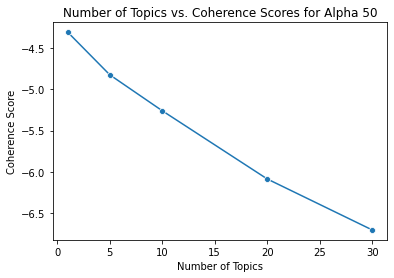

<Figure size 432x288 with 0 Axes>

In [13]:
model_dict_individual, coh_dict_individual = find_cv([1,5,10,20,30], corpus_ind, id2word_ind, 
                              'num_topics_coh_individual', '','',pretitle='individual_')

# coh_dict_collated = find_cv([1,10,20,30,50], corpus_col, id2word_col, 'num_topics_coh_collated')

In [9]:
### Filter out extreme words to improve CV

In [14]:
# Define a function to find out some important information about a corpus
def report_info(dictionary, corpus):
    # Input: dictionary created in preprocess_tweet_data
    # Find # of docs
    num_docs = dictionary.num_docs
    # Find # of total words (not unique words) in the document
    num_words = dictionary.num_pos
    print('Number of documents:', num_docs)
    print('Number of total words:', num_words)
    
    # Find unique number of words

    # Make list of all word ids that appear in corpus
    word_ids = []
    for i in corpus:
        for j in i:
            word_ids.append(j[0])

    # To find the unique # of words, find the max of the word id list
    num_unique_words = max(word_ids)+1
    print('Number of unique words:', num_unique_words)
    
    return num_docs, num_words, num_unique_words

In [15]:
# Make index of word IDs
def make_freq_list(corpus, num_unique_words):
    word_index = [i for i in range(num_unique_words)]

    # Make list that will correspond to the number of times each word appears in whole corpus,
    # beginning with 0
    freq_list = [0 for i in range(len(word_index))]

    # # Loop through each word in the corpus, adding the # of times that word appears in the corpus 
    for doc in corpus:
        for word in doc:
            # word[0] = word index, word[1] = frequency in document (not in whole corpus). 
            # Add freq in document to count by word index in freq_list - will give us freq in whole doc
            freq_list[word[0]] += word[1]  
    
    # Zip word index and freq together to form list of tuples where x = index of word, y = freq in corpus
    word_freq = list(zip(word_index, freq_list))
    
    return word_index, freq_list, word_freq
        
    
    

In [16]:
# Find the number of documents that each word appears in
def find_docfreq(corpus, word_index):
    # corpus = relevant corpus, word_index = index of all unique words
    
    # Make list that will correspond to the number of documents each word appears in at least once,
    # beginning with 0
    freq_list = [0 for i in range(len(word_index))]
    
    # Loop through each word in the corpus, adding 1 if word appears in a particular doc
    for doc in corpus:
        for word in doc:
            # word[0] = word index. if word index appears in doc, add 1
            freq_list[word[0]] += 1
    
    doc_freq = list(zip(word_index, freq_list))
    
    return doc_freq, freq_list

In [17]:
def corpus2info(dictionary, corpus):
    # Combine the above functions to report info about corpus & return two tuples with (x,y) 
    # where x=word index, y= # of times word appeared in corpus in tuple 1 & x = word index, y=# of documents word appeared in at least once
    num_docs, num_words, num_unique_words = report_info(dictionary, corpus)
    
    word_index, freq_list, word_freq = make_freq_list(corpus, num_unique_words)
    
    doc_freq, doc_freq_list = find_docfreq(corpus, word_index) 
    print('\n')
    
    for qt in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        print(f'The {str(int(qt*100))}th percentile document frequency is', np.quantile(doc_freq_list, qt))
        if qt == 0.8:
            eighty_percentile = int(round(np.quantile(doc_freq_list,qt),0))
        elif qt == 0.9:
            ninety_percentile = int(round(np.quantile(doc_freq_list,qt),0))
    print('The max document frequency is', max(doc_freq_list))
    return word_freq, doc_freq, eighty_percentile, ninety_percentile

In [18]:
word_freq_ind, doc_freq_ind, eighty_percentile_ind, ninety_percentile_ind = corpus2info(id2word_ind, corpus_ind)

Number of documents: 707346
Number of total words: 3036813
Number of unique words: 127682


The 10th percentile document frequency is 1.0
The 20th percentile document frequency is 1.0
The 30th percentile document frequency is 1.0
The 40th percentile document frequency is 1.0
The 50th percentile document frequency is 1.0
The 60th percentile document frequency is 1.0
The 70th percentile document frequency is 2.0
The 80th percentile document frequency is 4.0
The 90th percentile document frequency is 11.0
The max document frequency is 49084


In [31]:
word_freq, doc_freq, eighty_percentile, ninety_percentile = corpus2info(id2word_col, corpus_col)

Number of documents: 45277
Number of total words: 2953584
Number of unique words: 124037


The 10th percentile document frequency is 1.0
The 20th percentile document frequency is 1.0
The 30th percentile document frequency is 1.0
The 40th percentile document frequency is 1.0
The 50th percentile document frequency is 1.0
The 60th percentile document frequency is 1.0
The 70th percentile document frequency is 2.0
The 80th percentile document frequency is 3.0
The 90th percentile document frequency is 10.0
The max document frequency is 18518


(0, 45277)


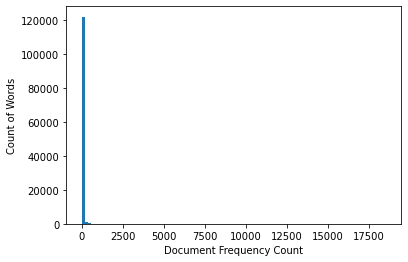

(1, 45277)


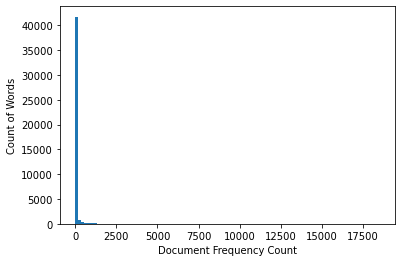

(2, 45277)


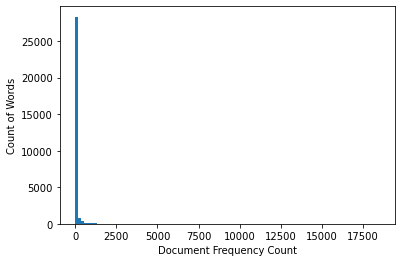

(3, 100)


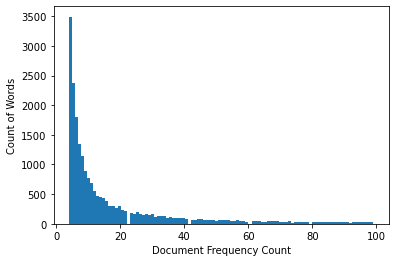

(3, 200)


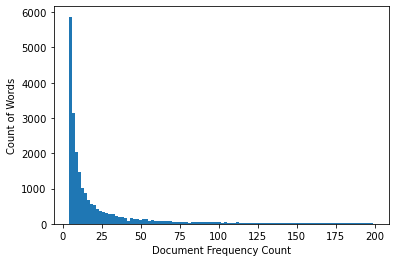

(3, 500)


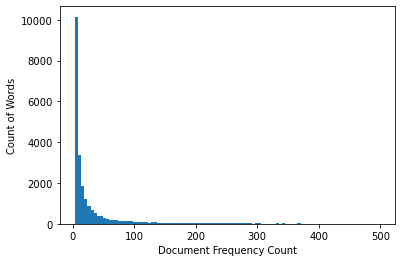

(3, 45277)


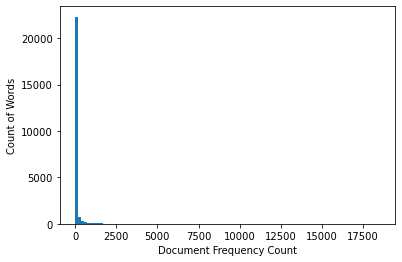

(4, 100)


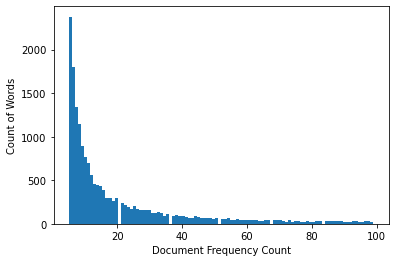

(4, 200)


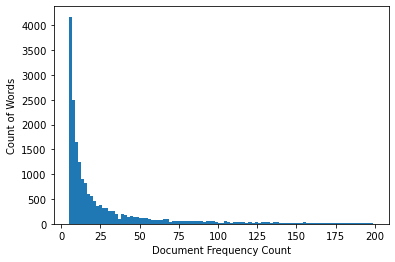

(4, 500)


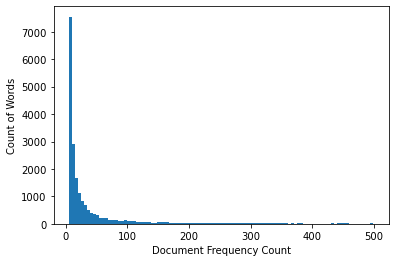

(5, 100)


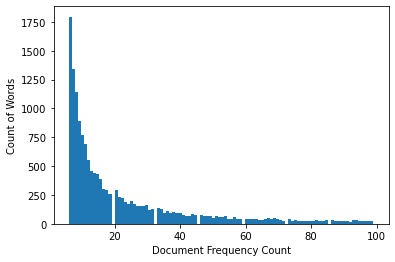

(5, 200)


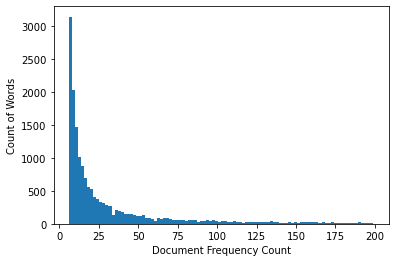

(5, 500)


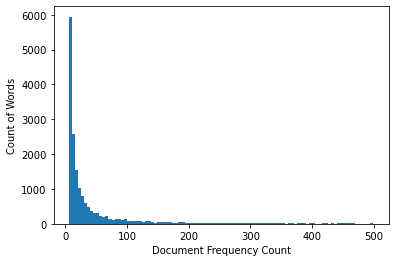

In [54]:
# Make a histogram of document frequencies (# of docs that each word appears in) for each possible filtering tuple
#(0,45277; 1,45277; 2,45277;3,100;3,200;3,500;3,45277;4,100;4,200;4,500;5,100;5,200;5,500)
doc_freq_list = []
for word in doc_freq:
    doc_freq_list.append(word[1])

def create_histogram(filter_tuple):
    print(filter_tuple)
    doc_freq_list_new = [i for i in doc_freq_list if i>filter_tuple[0] and i<filter_tuple[1]]
    plt.hist(doc_freq_list_new, bins=100)
    #plt.title(f"Histogram of Document Frequency Excluding Words in Fewer than {filter_tuple[0]} & More than {filter_tuple[1]} Documents")
    plt.ylabel('Count of Words')
    plt.xlabel('Document Frequency Count')
    plt.savefig(f'{cwd}{sep}figures{sep}histogram{sep}hist_{str(filter_tuple[0])}_{str(filter_tuple[1])}.jpg')
    plt.show()

    
# Filter tuple list
filter_tuple_list = [(0,45277), (1,45277), (2,45277), (3,100), (3,200), (3,500),
                     (3,45277),(4,100),(4,200),(4,500),(5,100), (5,200), (5,500)]

    
for filter_tuple in filter_tuple_list:
    create_histogram(filter_tuple)


In [109]:
# Filter out extremes from the corpus using the dictionary id2word
# no_below = 80th percentile of document frequency (gets rid of 80% of corpus)
# no_above = keep tokens contained in no more than _% of total corpus (recall, only 20% of corpus is left) 
# keep_n = 
# Create a function that will filter collated tweets using no_below, no_above
def filter_corpus_cv(no_below, no_above, save_as, cv_list = [1,10,20,30,50]):
    # Unpickle id2word_col & lemmatized texts
    id2word_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'rb'))
    texts = pickle.load(open(f'{data_dir}{sep}pickle{sep}collated_tweets_lemmatized.pickle', 'rb'))
    
    # Filter id2word col using below & above
    id2word_col.filter_extremes(no_below=no_below, no_above=no_above)
    print('New number of unique words!:', len(id2word_col))
    
    # Create filtered corpus
    corpus_filtered = [id2word_col.doc2bow(text) for text in texts]
    
    # Create a (blank) text file that will contain info on coh, topics, etc.
    no_below_txt = str(no_below)
    no_above_txt = str(int(round(no_above*len(corpus_filtered), 0)))
    model_output = open(f'{cwd}/output/model_output_nobelow_{no_below_txt}_noabove_{no_above_txt}.txt', 'w')
    L = ['No below: ', no_below_txt, "\n", "No above: ", no_above_txt, "\n", "\n"]
    model_output.writelines(L)
    model_output.close()
    
    # Run through various CV & alphas w/filtered dict & corpus. Return dictionary that contains model as values.
    model_dict_ab_bel = find_cv(cv_list, corpus_filtered, id2word_col, no_above_txt, no_below_txt, save_as)
    
    return model_dict_ab_bel
    

In [184]:
# # RAN BELOW CODE ON THE SERVER
# full_corpus_len = len(corpus_col)
# no_above_list = [1.0,round(100/full_corpus_len, 6), round(150/full_corpus_len, 6), round(200/full_corpus_len, 6), round(500/full_corpus_len, 6)]
# no_below_list = [0,1,2,3,4,5]
# full_model_dict = dict()
# full_cv_list = [1]
# to_append = [i for i in range(201) if i%10 == 0 and i != 0]
# full_cv_list.extend(to_append)

# # Run through vars in no_above_list and no_below_list, creating a full model nested dictionary that looks like the following:
# # full_model_dict[(no_above, no_below)]

# for no_above in no_above_list:
#     for no_below in no_below_list:
#         try:
#             full_model_dict = pickle.load(open(f'{cwd}/output/full_model_dict.pickle', 'wb'))
#         except:
#             pass
#         filter_tuple = (no_above, no_below)
#         no_below_txt = str(no_below)
#         no_above_txt = str(int(round(no_above*len(corpus_col), 0)))
#         print('modelling topics for ' + str(filter_tuple))
#         save_as = "no_below_"+no_below_txt+"_no_above_" + no_above_txt
#         full_model_dict[filter_tuple] = filter_corpus_cv(no_below, no_above, save_as, cv_list = full_cv_list)
#         # Pickle full model dict
#         pickle.dump(full_model_dict, open(f'{cwd}/output/full_model_dict.pickle', 'wb'))
        

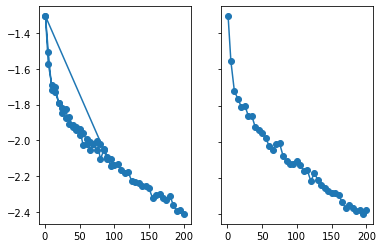

In [53]:
fig, axs = plt.subplots(1,2)
def coherence_subplot(no_below, no_above,ax1):
    no_below_txt = str(no_below)
    no_above_txt = str(no_above)
    with open(f"{cwd}{sep}output{sep}model_output_no_below_{no_below_txt}_no_above_{no_above_txt}.txt","r") as fi:
        num_topic_list = []
        coh_list = []
        for ln in fi:
            if ln.startswith('No. of topics:'):
                num_topic_list.append(int(ln[14:-1]))
            if ln.startswith("Coherence:"):
                coh_list.append(float(ln[10:-1]))

    # Graph coh vs. num topics
    # Plot # of topics against coherence
    x,y = [num for num in num_topic_list], [coh_value for coh_value in coh_list]
    axs[ax1].plot(x,y, marker='o')
    
coherence_subplot(0,45277,0)
coherence_subplot(1,45277,1)
# coherence_subplot(2,45277,1,0)
# coherence_subplot(3,45277,1,1)


# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
for ax in fig.get_axes():
    ax.label_outer()
    


(0, 45277)


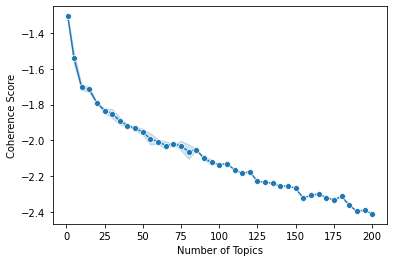

(1, 45277)


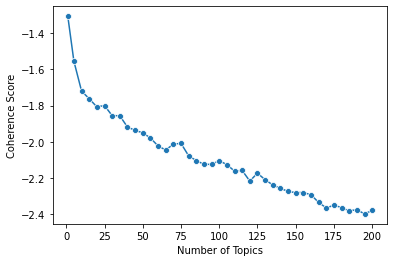

(2, 45277)


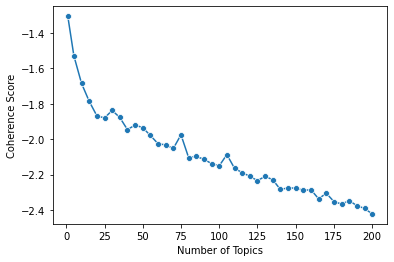

(3, 100)


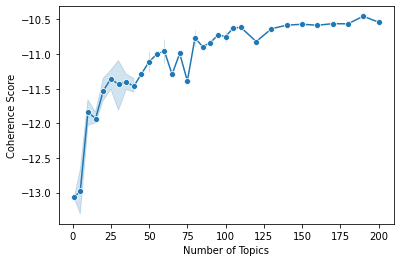

(3, 200)


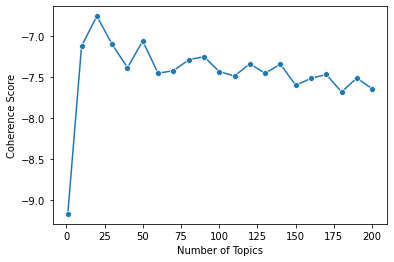

(3, 500)


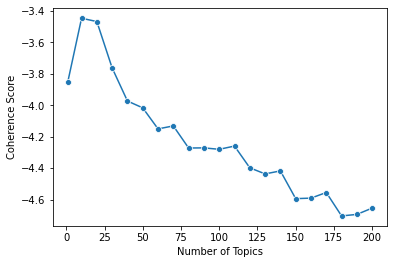

(3, 45277)


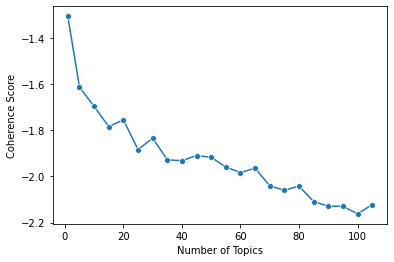

(4, 100)


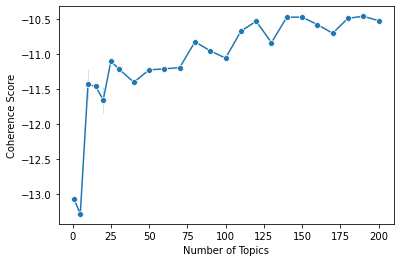

(4, 200)


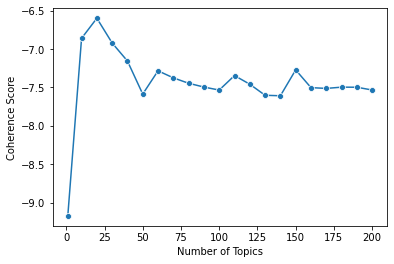

(4, 500)


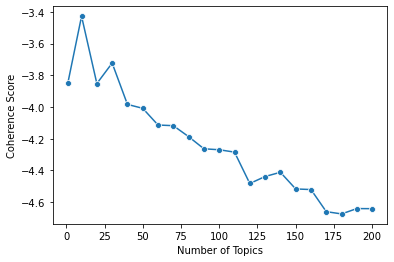

(5, 100)


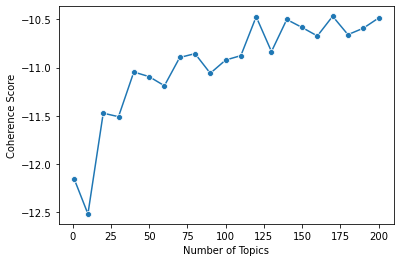

(5, 200)


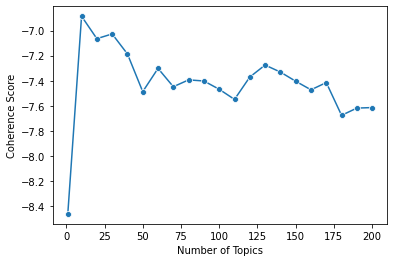

(5, 500)


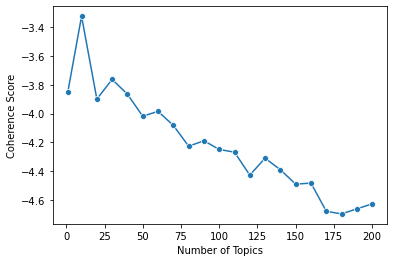

In [55]:
# Create graphs by reading in coherence dictionary info from the output 

below_above_tuples = [(0,45277), (1,45277), (2,45277), (3,100), (3,200), (3,500), (3,45277), (4,100), (4,200), (4,500), (5,100), (5,200), (5,500)]
for tup in below_above_tuples:
    print(tup)
    no_below = tup[0]
    no_above = tup[1]
    
    no_below_txt = str(no_below)
    no_above_txt = str(no_above)
    with open(f"{cwd}{sep}output{sep}model_output_no_below_{no_below_txt}_no_above_{no_above_txt}.txt","r") as fi:
        num_topic_list = []
        coh_list = []
        for ln in fi:
            if ln.startswith('No. of topics:'):
                num_topic_list.append(int(ln[14:-1]))
            if ln.startswith("Coherence:"):
                coh_list.append(float(ln[10:-1]))

    # Graph coh vs. num topics
    # Plot # of topics against coherence
    x,y = [num for num in num_topic_list], [coh_value for coh_value in coh_list]
    sns.lineplot(x=x,y=y,marker='o')
    save_as = f"coh_filtered_no_below_{no_below_txt}_no_above_{no_above_txt}"
#     plt.title(f'Number of Topics vs. Coherence Scores for Filtered Output: No Below {no_below_txt} & No Above {no_above_txt}')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.savefig(f'{cwd}{sep}figures{sep}coh_scores{sep}{save_as}.png')
    plt.show()





In [10]:
# # Create graphs by reading in coherence dictionary info from the output 
# #below_above_tuples = [(0,45277), (1,45277), (2,45277), (3,100), (3,200), (3,500), (3,45277), (4,100), (4,200), (4,500), (5,100), (5,200), (5,500)]
# below_above_tuples = [(3,200)]
# for tup in below_above_tuples:
#     print(tup)
#     no_below = tup[0]
#     no_above = tup[1]
    
#     no_below_txt = str(no_below)
#     no_above_txt = str(no_above)
#     with open(f"{cwd}{sep}output{sep}model_output_no_below_{no_below_txt}_no_above_{no_above_txt}.txt","r") as fi:
#         topics_list = []
#         for ln in fi:
#             if ln.startswith('Model topics:'):
#                 print(ln[14:])
#                 print('\n')
#                 #topics_list.append(ln[10:-1])
#         #print(topics_list)
#     print('\n \n')



In [10]:
# Read in pickled data for full sample to find some information about it
id2word_col_ym = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_ym_all.pickle', 'rb'))
texts = pickle.load(open(f'{data_dir}{sep}pickle{sep}ym_collated_tweets_lemmatized_all.pickle', 'rb'))

corpus_col_ym = [id2word_col_ym.doc2bow(text) for text in texts]


Number of documents: 73354
Number of total words: 20908943
Number of unique words: 438895


The 10th percentile document frequency is 1.0
The 20th percentile document frequency is 1.0
The 30th percentile document frequency is 1.0
The 40th percentile document frequency is 1.0
The 50th percentile document frequency is 1.0
The 60th percentile document frequency is 1.0
The 70th percentile document frequency is 2.0
The 80th percentile document frequency is 3.0
The 90th percentile document frequency is 8.0
The max document frequency is 50714


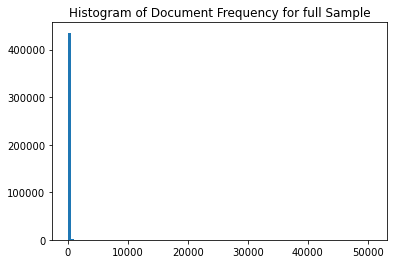

In [11]:
# Report info about full corpus
word_freq, doc_freq, eighty_percentile, ninety_percentile = corpus2info(id2word_col_ym, corpus_col_ym)

# Create histo
doc_freq_list = []
for word in doc_freq:
    doc_freq_list.append(word[1])

plt.hist(doc_freq_list, bins=100)
plt.title(f"Histogram of Document Frequency for full Sample")
plt.savefig(f'{cwd}{sep}figures{sep}hist_full_sample.jpg')
plt.show()


In [12]:
# Filter to 4,500 and try again
# Filter id2word col using below & above
id2word_col_ym.filter_extremes(no_below=4, no_above=500/73354)
print('New number of unique words!:', len(id2word_col_ym))
    
# Create filtered corpus
corpus_filtered = [id2word_col_ym.doc2bow(text) for text in texts]

New number of unique words!: 72179


Number of documents: 73354
Number of total words: 20908943
Number of unique words: 72179


The 10th percentile document frequency is 4.0
The 20th percentile document frequency is 5.0
The 30th percentile document frequency is 6.0
The 40th percentile document frequency is 7.0
The 50th percentile document frequency is 9.0
The 60th percentile document frequency is 13.0
The 70th percentile document frequency is 20.0
The 80th percentile document frequency is 35.0
The 90th percentile document frequency is 82.0
The max document frequency is 500


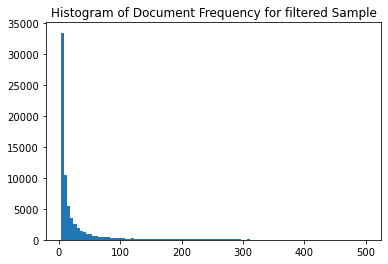

In [13]:
# Report info about filtered corpus
word_freq, doc_freq, eighty_percentile, ninety_percentile = corpus2info(id2word_col_ym, corpus_filtered)

# Create histo
doc_freq_list = []
for word in doc_freq:
    doc_freq_list.append(word[1])

doc_freq_list_new = [i for i in doc_freq_list if i>3 and i<501]

plt.hist(doc_freq_list_new, bins=100)
plt.title(f"Histogram of Document Frequency for filtered Sample")
plt.savefig(f'{cwd}{sep}figures{sep}hist_filtered_sample.jpg')
plt.show()

In [18]:
# Given the list of topics, find volume/distribution of topics across the documents
# Create dataframe that corresponds to the order of the topic distribution list (created on server)

In [3]:
english_tweets_train = pickle.load(open(f'{data_dir}{sep}pickle{sep}english_tweets_train.pickle', 'rb'))
english_tweets_test = pickle.load(open(f'{data_dir}{sep}pickle{sep}english_tweets_test.pickle', 'rb'))
english_tweets_val = pickle.load(open(f'{data_dir}{sep}pickle{sep}english_tweets_val.pickle', 'rb'))


In [4]:
#Combine test/val (to match how the tweets were collated)
english_tweets_all = english_tweets_test.append(english_tweets_val)

In [12]:
ym_list = [year_month for year_month in english_tweets_train['ym'].unique()]


In [15]:
# Now collapse to get the unique ym LocationCT IN CORRECT CENSUS TRACT ORDER (so do not sort) 
train_ym_ct_orig = english_tweets_train[english_tweets_train['lang'] == 'en'].groupby(['ym', 'LocationCT'], sort=False)\
                    .count().reset_index()[['LocationCT', 'ym']]

In [17]:
test_val_ym_ct_orig = english_tweets_all[english_tweets_all['lang'] == 'en'].groupby(['ym', 'LocationCT'], sort=False)\
                    .count().reset_index()[['LocationCT', 'ym']]

In [25]:
# train_ym_ct and test_val_ym_ct need to have their yms be in the order of ym_list. So run through ym list and append
# to another dataset
train_ym_ct = pd.DataFrame()
test_val_ym_ct = pd.DataFrame()

for ym in ym_list:
    train_ym = train_ym_ct_orig[train_ym_ct_orig['ym'] == ym]
    test_val_ym = test_val_ym_ct_orig[test_val_ym_ct_orig['ym'] == ym]
    
    train_ym_ct = train_ym_ct.append(train_ym).reset_index(drop=True)
    test_val_ym_ct = test_val_ym_ct.append(test_val_ym).reset_index(drop=True)

In [86]:
# Combine the two datasets
all_ym_ct = train_ym_ct.append(test_val_ym_ct).reset_index(drop=True)
# pickle.dump(all_ym_ct, open(f'{data_dir}{sep}pickle{sep}all_ym_ct.pickle', 'wb'))

In [12]:
# Bring in the topic distribution list
all_ym_ct = pickle.load(open(f'{data_dir}{sep}pickle{sep}all_ym_ct.pickle', 'rb'))
topic_distribution_list = pickle.load(open(f'{cwd}{sep}output{sep}topic_distribution_list.pickle', 'rb'))

In [13]:
# Make into dataframe where column i = topic i, and row = ym/census tract
column_names = ['topic'+str(i) for i in range(45)]
topic_dist = pd.DataFrame.from_records(topic_distribution_list, columns=column_names)

In [14]:
# Merge with all_ym_ct (order)
topic_dist_df = all_ym_ct.merge(topic_dist, left_index=True, right_index=True)

In [15]:
# Create dataframe averaging out topic distributions by LocationCT and another repping temporal change
topic_dist_avg = topic_dist_df.groupby('LocationCT').mean().reset_index()
topic_dist_max = topic_dist_df.groupby('LocationCT').max().reset_index()

In [16]:
topic_dist_temp = topic_dist_df.pivot_table(index='LocationCT', columns='ym', values=column_names).reset_index()
topic_dist_temp.columns = ["_".join(a) for a in topic_dist_temp.columns.to_flat_index()]
topic_dist_temp = topic_dist_temp.rename(columns={'LocationCT_':'LocationCT'})

In [17]:
# Pickle the four dataframes created
pickle.dump(topic_dist_df, open(f'{data_dir}{sep}pickle{sep}topic_dist_df.pickle', 'wb'))
pickle.dump(topic_dist_avg, open(f'{data_dir}{sep}pickle{sep}topic_dist_avg.pickle', 'wb'))
pickle.dump(topic_dist_temp, open(f'{data_dir}{sep}pickle{sep}topic_dist_temp.pickle', 'wb'))
pickle.dump(topic_dist_max, open(f'{data_dir}{sep}pickle{sep}topic_dist_max.pickle', 'wb'))

In [6]:
# topic_dist_max